In [2]:

# Importing relevant packages
import cv2
import numpy as np
import pims
import trackpy as tp
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from copy import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#%matplotlib tk # uncomment dit als je interactieve plots wilt hebben (je moet de kernel restarten als je dit weer uit wilt zetten)

## Loading in video
In the cell below you can put the name of the video you want to be analysed. Make sure you put the video in the same folder as where the file with this code is put.

In [3]:
fileName = r'Tracking_videos\25-4-2025\20250425_135333.mp4'

In [4]:
video = pims.Video(fileName) # Loading in video and converting them to individual frames
duration = video.duration # Duration of video in seconds
frameRate = video.frame_rate # Framerate of video

print(f'duration:{round(duration,3)}, framerate: {round(frameRate,3)}, # of frames: {round(duration * frameRate)}')

duration:25.466, framerate: 30.001, # of frames: 764


Use the snippet of code underneath if you want to only analyse a selection of frames. When working with large videos it is advisable to first test your code on a small selection of frames. This way you can quickly see if everything works as expected!

In [5]:
startframe = 0
endframe = len(video)
frames = video[startframe:endframe]
print('Amount of frames:', len(frames))

Amount of frames: 764


In [6]:
def boatCentre(frames, shorten = 1, reducefps = 3, colorthreshold = 0.3):
    """
    Args:
        frames: frames to be analysed
        shorten: how much of the video needs to be analyzed. (1 is everything)
        reducefps: reduce the amount of frames used i.e. every n'th frame.
        colorthreshold: threshold value for when to count the pixel as a tracking cap 0 means everything counts

    Returns:
       positions [np.array]: list of frames with only the positions of the tracking dots highlited.
       blurs [np.array]: list of frames with the results of the blurring and clipping shown.
       newset [np.array]: list of original frames with the tracked dots highlited with circles.
       circstore [list]: list with lists of tuples containing the information (pos & radius) of each circle per frame.
       indecesused [list]: list of the indeces corresponding to the frames that were processed from the frames input.
    """

    circstore = [] # list of lists with tuples containing the info of the circles per frame
    positions, blurs, newset = [], [], [] #lists to be filled with their respective frame types
    indecesused = [] #

    for i in range(0,int(len(frames)/shorten),reducefps):
        indecesused.append(i)
        cimg= copy(frames[i]) # makes a copy of the original frame as to not edit over the original

        r,gr,b = cv2.split(frames[i]) # split the color image into different channels    
        blurthis = (abs((r/255)-(gr/255))+abs((gr/255)-(b/255))+abs((r/255)-(b/255))) # calculate the color difference for each pixel from 0-1 (this highlights pixels with a lot of a single color)

        blurthis[blurthis>=colorthreshold] = 255 # set color difference values above a threshold to max intensity
        blurthis[blurthis<colorthreshold] = 0 # set color difference values below the same threshold to zero intenisty
        blur = cv2.medianBlur(np.uint8(blurthis), ksize=9) # blur to help houghcircles. If all went well, only the colored dots on the cheerioboat remain.

        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.5, minDist=35, param1=60, param2=10, minRadius=4, maxRadius=20) # actually find the circles in the edited image  #60,10
        circles = np.uint16(np.around(circles)) # round the found circle positions and radii
        
        circstore.append(circles) # save the positions and radii of the circles
        # blur = cv2.cvtColor(blur,cv2.COLOR_GRAY2RGB)

        background = np.zeros_like(blur, np.uint8) # create a black greyscale background 
    
        for j in circles[0,:]:
            # draw the centers of the circles
            cv2.circle(background,(j[0],j[1]),3,(255,0,0),-1) 
            cv2.circle(blur,(j[0],j[1]),3,255, -1) 
            cv2.circle(cimg,(j[0],j[1]),3,(255,0,0),-1) 
            
            # draw the edge of the circles
            # cv2.circle(background,(i[0],i[1]),i[2],(0,255,0),1)
            cv2.circle(blur,(j[0],j[1]),j[2],(0,255,0),1)
            cv2.circle(cimg,(j[0],j[1]),j[2],(0,255,0),1)
        
        positions.append(background)
        blurs.append(blur)
        newset.append(cimg)

        print('finished frame:', i)
    
    return np.array(positions), np.array(blurs), np.array(newset), circstore, indecesused

## Editing all frames

In [7]:
positions, _, newset, _, indecesused,= boatCentre(frames, reducefps=3) # returns frames with dots placed in the centre of mass of the boats for all frames

# print('aantal cirkels:', int(len(np.ndarray.flatten(np.array(circstore)))/3))

finished frame: 0
finished frame: 3
finished frame: 6
finished frame: 9
finished frame: 12
finished frame: 15
finished frame: 18
finished frame: 21
finished frame: 24
finished frame: 27
finished frame: 30
finished frame: 33
finished frame: 36
finished frame: 39
finished frame: 42
finished frame: 45
finished frame: 48
finished frame: 51
finished frame: 54
finished frame: 57
finished frame: 60
finished frame: 63
finished frame: 66
finished frame: 69
finished frame: 72
finished frame: 75
finished frame: 78
finished frame: 81
finished frame: 84
finished frame: 87
finished frame: 90
finished frame: 93
finished frame: 96
finished frame: 99
finished frame: 102
finished frame: 105
finished frame: 108
finished frame: 111
finished frame: 114
finished frame: 117
finished frame: 120
finished frame: 123
finished frame: 126
finished frame: 129
finished frame: 132
finished frame: 135
finished frame: 138
finished frame: 141
finished frame: 144
finished frame: 147
finished frame: 150
finished frame: 15

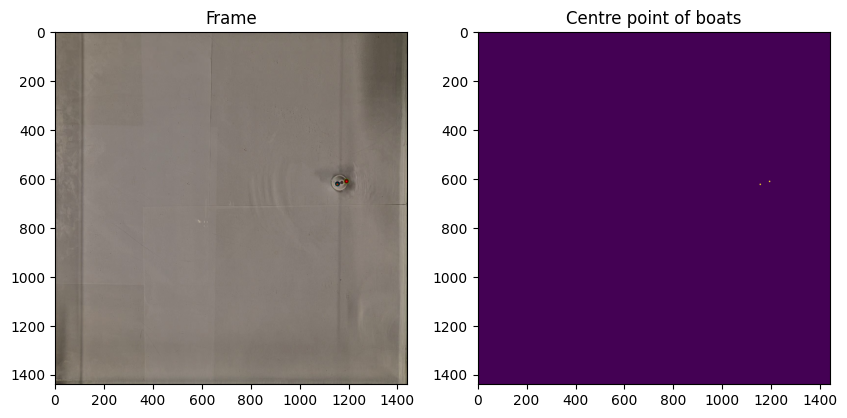

In [8]:

fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].imshow(newset[0])
axs[0].set_title('Frame')
axs[1].imshow(positions[0])
axs[1].set_title('Centre point of boats')

plt.show()

The cell below will search for all the dots we put in the frames and save their positions.
We've now got locations for all our dots! But to get information on the movement of the boats it is important that we can label boats. The code snippet below will compare all our dots frame by frame and detect which ones are which boat.

In [9]:
f = tp.batch(positions, diameter=5, minmass=20, processes='auto', invert=False)#37

t = tp.link(f, search_range=140, memory=20)# WAS 90
# t = tp.filter_stubs(t,t['frame'].max() * 0.70 )

framelist = list(set(t['frame'])) # create a list of all available frame numbers

t

Frame 254: 2 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,613.856934,1189.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,0,0
1,625.856934,1151.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,0,1
2,610.856934,1165.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,1,0
3,623.856934,1127.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,1,1
4,610.856934,1145.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...
503,859.856934,145.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,252,1
506,874.856934,163.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,253,0
505,857.856934,130.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,253,1
508,874.856934,151.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,254,0


In [19]:
# calculate the centre of the boat
x = []
y = []

for framenr in framelist:
    x.append(0.5 * sum(t.loc[t['frame'] == framenr]['x']))
    y.append(0.5 * sum(t.loc[t['frame'] == framenr]['y']))



In [10]:
theta = []
particles = list(set(t['particle']))
for framenr in framelist:
    tt = t[t['frame'] == framenr]
    try: # calculate the angle of the particle with respect to an arbitrary axis
        dx = float((tt.loc[tt['particle'] == particles[1], ['x']]).iloc[0]) - float((tt.loc[tt['particle'] == particles[0], ['x']]).iloc[0])
        dy = float((tt.loc[tt['particle'] == particles[1], ['y']]).iloc[0]) - float((tt.loc[tt['particle'] == particles[0], ['y']]).iloc[0])
        theta.append(np.arctan(np.abs(dy/dx)))
    except: # if a frame does not have every particle, repeat the previous value
        theta.append(theta[-1])


# from the obtained angles, calculate the angular velocity in terms of radians per frame
omega = (np.insert(theta, 0, 0) - np.insert(theta, -1, 0))[1:-1] / (np.insert(framelist, 0, 0) - np.insert(framelist, -1, 0))[1:-1]


(0.0, 254.0)

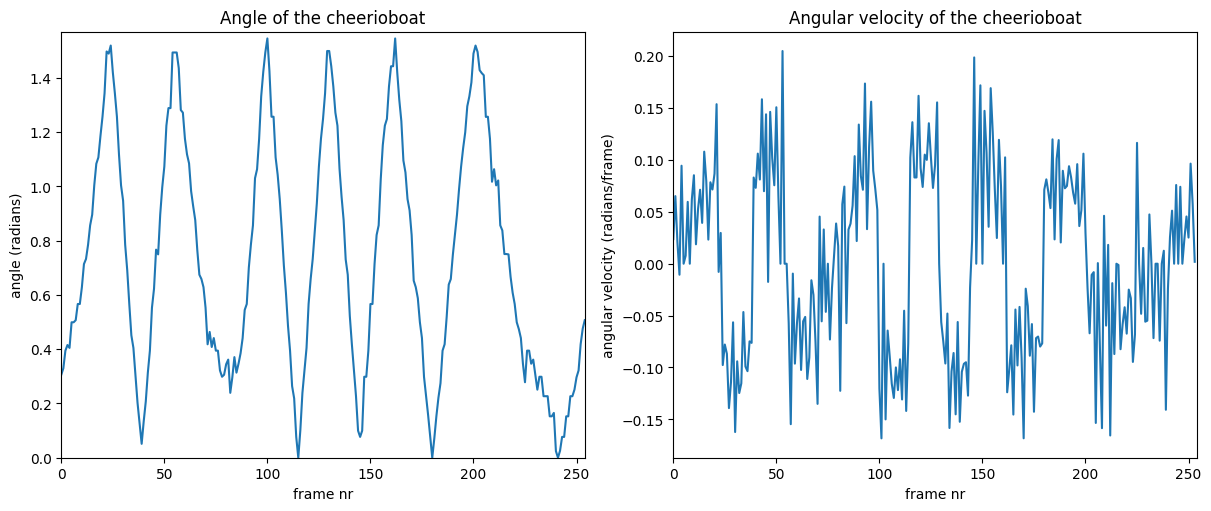

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

ax1.plot(framelist, theta)
ax1.set_title('Angle of the cheerioboat')
ax1.set_xlabel('frame nr')
ax1.set_ylabel('angle (radians)')
ax1.set_xlim(min(framelist), max(framelist))
ax1.set_ylim(0, np.pi / 2)

ax2.plot(framelist[:-1], omega)
ax2.set_title('Angular velocity of the cheerioboat')
ax2.set_xlabel('frame nr')
ax2.set_ylabel('angular velocity (radians/frame)')
ax2.set_xlim(min(framelist), max(framelist))

fig.savefig()

TypeError: title() missing 1 required positional argument: 'label'

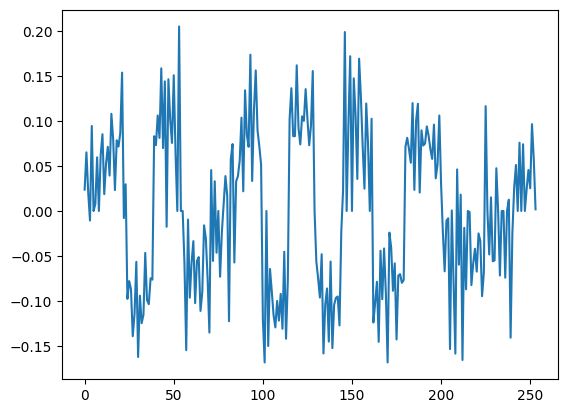

In [14]:

plt.plot(framelist[:-1], omega)
plt.title()
plt.xlabel('frame nr')
plt.ylabel()
plt.xlim(min(framelist), max(framelist))
plt.show()

## Average speed

In [ ]:
displacement = []
averageSpeed = []
for i in list(set(t['particle'])):
    tt = t.loc[t['particle'] == i]
    tt = tt.reset_index()
    S = 0 
    for j in range(1, len(tt['x'])):
        ds = np.sqrt((tt['x'].iloc[j] - tt['x'].iloc[j - 1])**2 + (tt['y'].iloc[j] - tt['y'].iloc[j - 1])**2)
        S = S + ds
    displacement.append(S)
    averageSpeed.append(S/duration)

data = {
    'particle':  list(set(t['particle'])),
    'displacement' : displacement,
    'averageSpeed' : averageSpeed
}
df = pd.DataFrame(data)
display(df)

   particle  displacement  averageSpeed
0         0   4815.701728    189.103186
1         1   4878.817469    191.581617


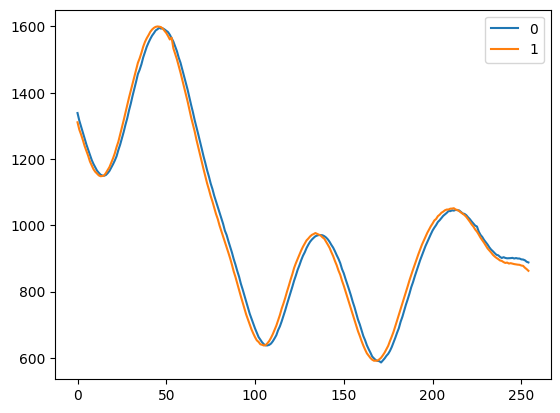

In [17]:
if t['particle'].max() != 0:
    for i in list(set(t['particle'])):
        tt = t.loc[t['particle']==i]
        plt.plot(tt['frame'], np.sqrt(tt['y']**2 + tt['x']**2), label = i)
else:
    plt.plot(tt['frame'], np.sqrt(tt['y']**2 + tt['x']**2), label = 0)
plt.legend()
plt.show()

We've now got the trajectory of our boats! :D